# Load data from google drive

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/age_gender.csv'

df = pd.read_csv(file_path)

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


# Verify how long pixel strings are.

In [ ]:
pixel_len = df['pixels'].apply(lambda x: len(x.split()))
max(pixel_len), min(pixel_len)

(2304, 2304)

# Note that all images are of size 2304 which is 48 * 48

# Lets have a glimps of an Image

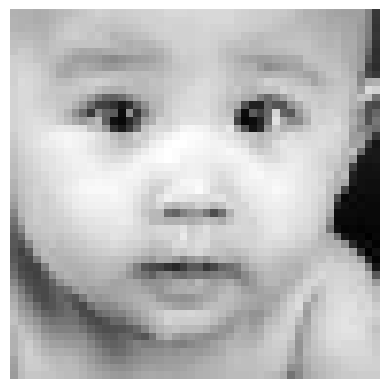

In [ ]:
import matplotlib.pyplot as plt

pixel_values_str = df['pixels'][0]

pixel_values = [int(val) for val in pixel_values_str.split()]

width = 48
height = 48

image_array = np.array(pixel_values, dtype=np.uint8)

image_array = image_array.reshape((height, width, 1))
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()


# Helper function to convert pixel string into image matrix

In [ ]:
def get_image(pixel_values_str):
    height = 48
    width = 48

    pixel_values = [int(val) for val in pixel_values_str.split()]

    image_array = np.array(pixel_values, dtype=np.uint8)

    image_array = image_array.reshape((height, width, 1))
    return image_array

# Convert each pixel string into image matrix and prepare X and y, where X contains all image matrix across data and y is age against each image

In [ ]:
X = df['pixels'].apply(get_image)
y = df['age']

# Train, Validation and Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
batch_size = 32

#train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255  # Normalize pixel values to [0, 1]
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)



In [ ]:
len(X_train), len(X_val), len(X_test)

(18964, 2370, 2371)

# Designing a CNN from scratch

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('relu'))

learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mean_squared_error', optimizer=optimizer)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 21, 21, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                 

# Start Training

In [ ]:
epochs = 200
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/200
593/593 [==============================] - 17s 9ms/step - loss: 411.1804 - val_loss: 271.0235
Epoch 2/200
593/593 [==============================] - 4s 6ms/step - loss: 196.8745 - val_loss: 167.4645
Epoch 3/200
593/593 [==============================] - 4s 6ms/step - loss: 159.0485 - val_loss: 150.5009
Epoch 4/200
593/593 [==============================] - 5s 8ms/step - loss: 142.8318 - val_loss: 137.2450
Epoch 5/200
593/593 [==============================] - 4s 6ms/step - loss: 132.5453 - val_loss: 125.8233
Epoch 6/200
593/593 [==============================] - 4s 6ms/step - loss: 126.2948 - val_loss: 133.7224
Epoch 7/200
593/593 [==============================] - 5s 8ms/step - loss: 119.2188 - val_loss: 194.9004
Epoch 8/200
593/593 [==============================] - 4s 6ms/step - loss: 114.6067 - val_loss: 244.3273
Epoch 9/200
593/593 [==============================] - 4s 6ms/step - loss: 110.0603 - val_loss: 216.3300
Epoch 10/200
593/593 [==============================] 

# Predict Test Data

In [ ]:
X_test1 = np.stack(X_test, axis=0)
X_test1 = X_test1*1/255
result = model.predict(X_test1)

75/75 [==============================] - 0s 3ms/step


# Verify prediction result against ground truth

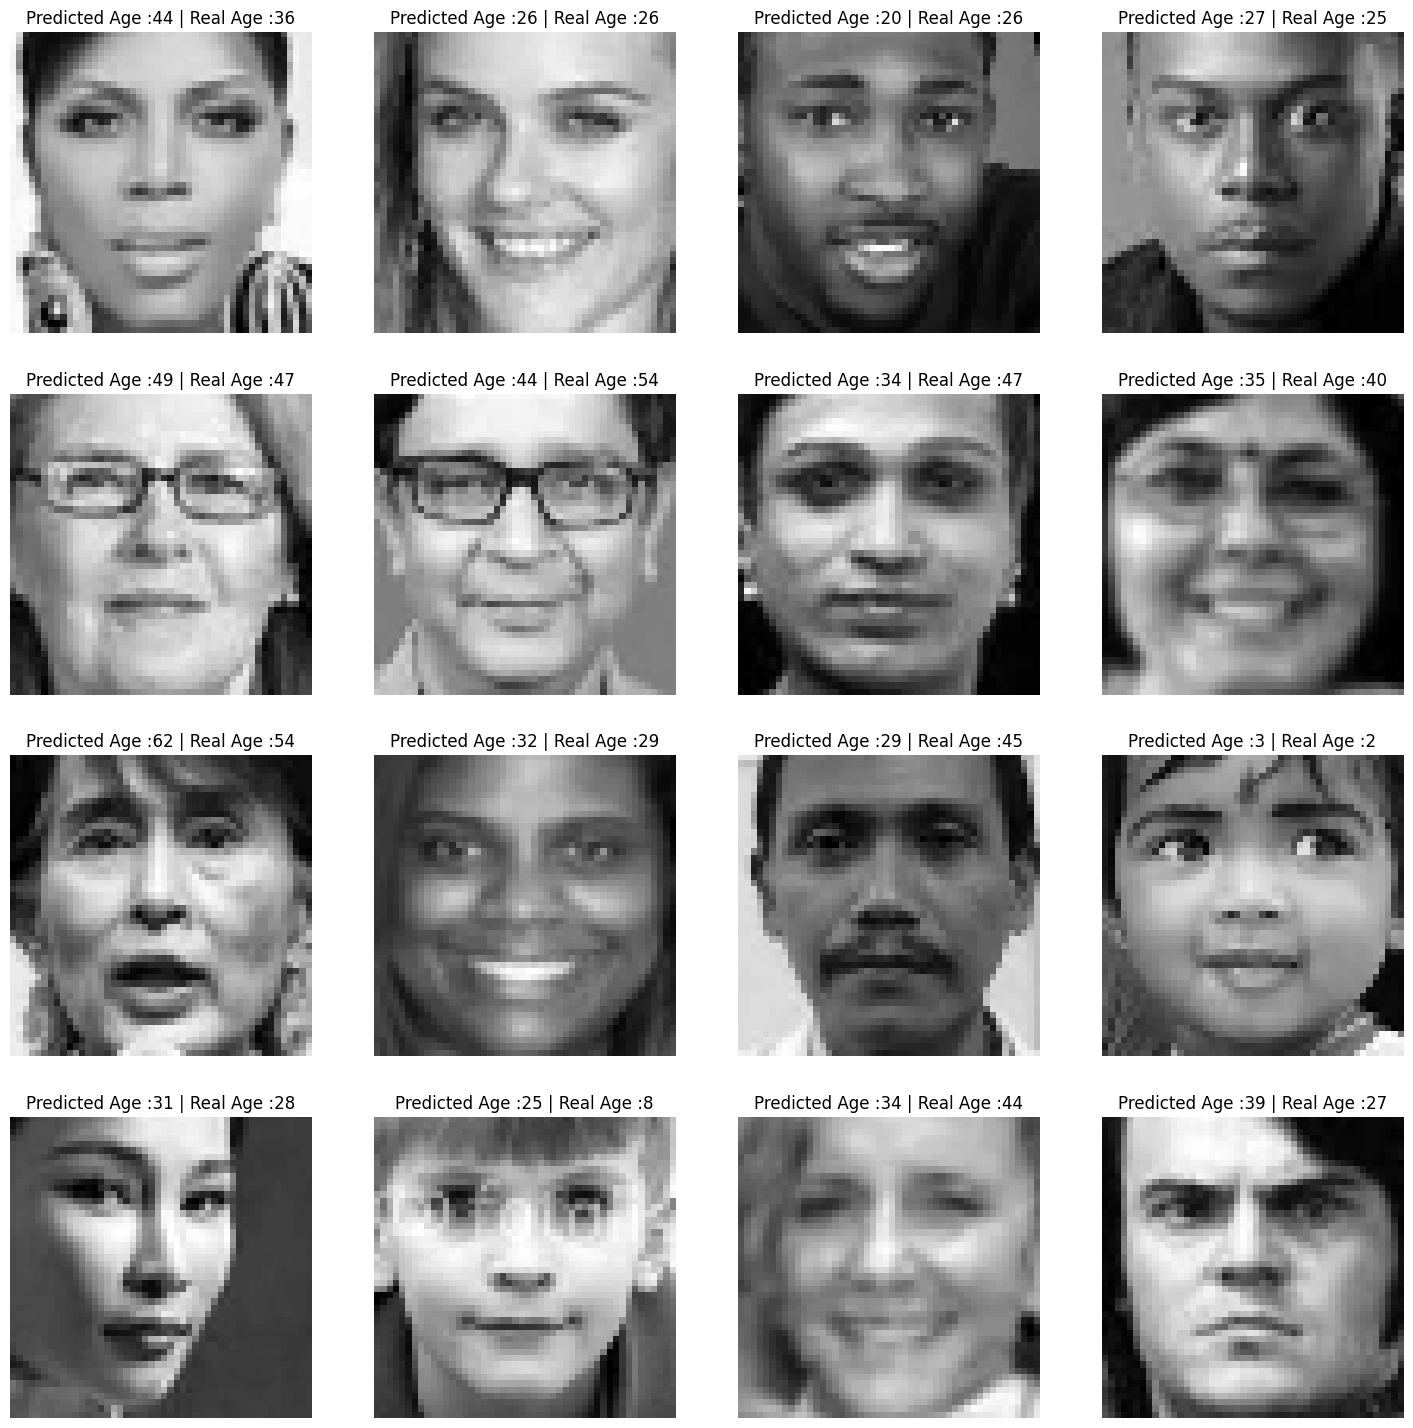

In [ ]:
index=20
dim=4
_, ax = plt.subplots(dim,dim, figsize=(18,18))
y_test = list(y_test)
i=0
for i in range(dim):
  for j in range(dim):
    ax[i,j].imshow(X_test1[index], cmap='gray')
    ax[i,j].set_title("Predicted Age :" + str(int(result[index][0])) + " | Real Age :" + str(y_test[index]))
    ax[i,j].axis('off')
    index += 1
plt.show()

# Calculate MSE and R-Squared on total test data.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(result, y_test)
r2 = r2_score(result, y_test)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 93.01207937153835
R-squared (R2) Score: 0.6933823561311091


# Now lets try to improve model performence

# Create another CNN archtecture which will use VGG16 loded with imagenet weights

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load the pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential()
model.add(Conv2D(3, (1, 1), input_shape=input_shape))
# Add the pre-trained VGG16 base model
model.add(base_model)
#model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mean_squared_error', optimizer=optimizer)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 3)         6         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 activation_11 (Activation)  (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14747591 (56.26 MB)
Trainable params: 14

# Start Training

In [ ]:
epochs = 200
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/200
593/593 [==============================] - 31s 44ms/step - loss: 304.2064 - val_loss: 159.9942
Epoch 2/200
593/593 [==============================] - 26s 44ms/step - loss: 206.5240 - val_loss: 126.6167
Epoch 3/200
593/593 [==============================] - 26s 44ms/step - loss: 163.9547 - val_loss: 136.1603
Epoch 4/200
593/593 [==============================] - 26s 44ms/step - loss: 142.8344 - val_loss: 99.9122
Epoch 5/200
593/593 [==============================] - 26s 44ms/step - loss: 134.7974 - val_loss: 127.3031
Epoch 6/200
593/593 [==============================] - 26s 43ms/step - loss: 119.0116 - val_loss: 108.3716
Epoch 7/200
593/593 [==============================] - 26s 44ms/step - loss: 118.5324 - val_loss: 96.1093
Epoch 8/200
593/593 [==============================] - 25s 43ms/step - loss: 106.7170 - val_loss: 148.0624
Epoch 9/200
593/593 [==============================] - 26s 44ms/step - loss: 104.4257 - val_loss: 93.8372
Epoch 10/200
593/593 [==================

# Save the trained model

In [ ]:
model_path = '/content/drive/MyDrive/age_detection1.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load the trained model

In [ ]:
from keras.models import load_model
model_path = '/content/drive/MyDrive/age_detection.h5'
loaded_model = load_model(model_path)

# Prediction

In [ ]:
X_test1 = np.stack(X_test, axis=0)
X_test1 = X_test1*1/255
result = loaded_model.predict(X_test1)

75/75 [==============================] - 1s 12ms/step


# Verify prediction result against ground truth

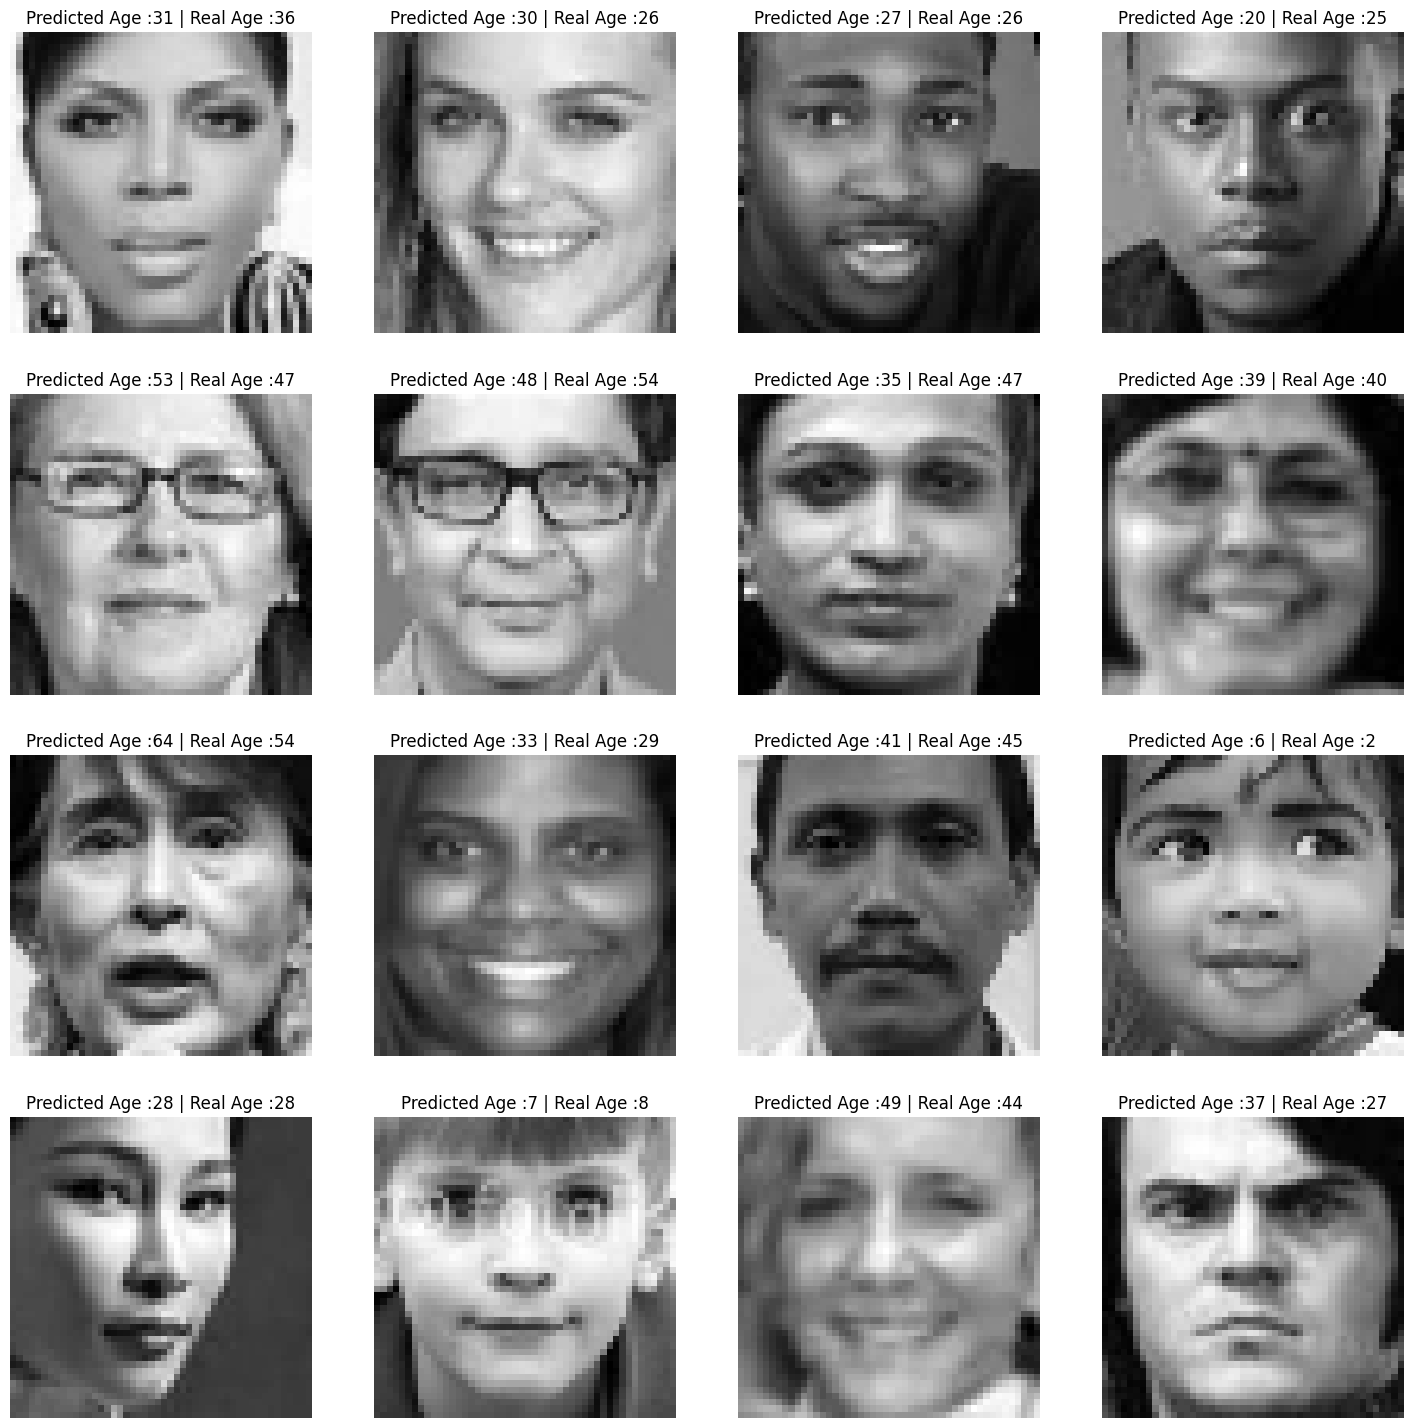

In [ ]:
index=20
dim=4
_, ax = plt.subplots(dim,dim, figsize=(18,18))
y_test = list(y_test)
i=0
for i in range(dim):
  for j in range(dim):
    ax[i,j].imshow(X_test1[index], cmap='gray')
    ax[i,j].set_title("Predicted Age :" + str(int(result[index][0])) + " | Real Age :" + str(y_test[index]))
    ax[i,j].axis('off')
    index += 1
plt.show()

# Now calculate MSE and R-Squared on total test data

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(result, y_test)
r2 = r2_score(result, y_test)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 66.50256771290326
R-squared (R2) Score: 0.8020337896724345


# Note that we have significetly improved model performence using VGG16

# MSE on test has decreased from 93 to 65 and R square has improved from 69 to 79

# Model performence can further be improved by finetunning a model which is specifically trained on face data such as VGGFace

# Make Prediction

In [ ]:
from keras.models import load_model
model_path = '/content/drive/MyDrive/age_detection.h5'
loaded_model = load_model(model_path)

1/1 [==============================] - 0s 66ms/step


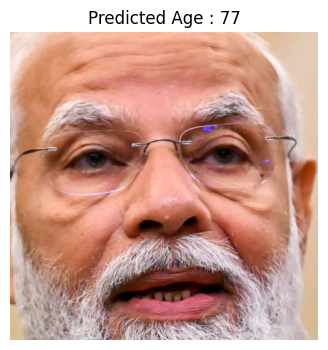

In [ ]:
import cv2
import re
import matplotlib.pyplot as plt

# Function to display large text in Jupyter Notebook
def print_large(text, font_size=18):
    text = re.sub('\n', '<br/>', text)
    html_text = f"<p style='font-size:{font_size}px'>{text}</p>"
    from IPython.core.display import display, HTML
    display(HTML(html_text))

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image
image_path = 'modi.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Select the face with the largest bounding box (most probable)
largest_face = None
largest_area = 0

for (x, y, w, h) in faces:
    area = w * h
    if area > largest_area:
        largest_area = area
        largest_face = (x, y, w, h)

# Crop and display the selected face
if largest_face is not None:
    x, y, w, h = largest_face
    selected_face = image[y:y+h, x:x+w]

    # Display the selected face
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(selected_face, cv2.COLOR_BGR2RGB))

    selected_face.shape
    gray_image = cv2.resize(selected_face, (48, 48))
    gray_image.shape

    gray_image = gray_image[:, :, 1]
    gray_image = gray_image.reshape((48, 48, 1))
    gray_image = gray_image*1/255
    gray_image = gray_image.reshape(1,48, 48, 1)
    result = loaded_model.predict(gray_image)
    plt.title("Predicted Age : "+str(int(result[0][0])))

    plt.axis('off')
    #plt.title('Selected Face')
    plt.show()
else:
    print_large("No face found")


